<a href="https://colab.research.google.com/github/GrizzlyEnglish/cse-621-final/blob/main/CSE_621_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
import gdown
!pip install -q transformers
from transformers import pipeline
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
from itertools import chain
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from transformers import BertTokenizer
from transformers import pipeline
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
from itertools import chain
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
import torch.nn as nn
from transformers import BertModel
from transformers import AdamW, get_linear_schedule_with_warmup
import random
import time
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
from wordcloud import WordCloud
import imageio
from pathlib import Path
import matplotlib.pyplot as plt
import re

stop_words = set(stopwords.words('english'))
stop_words.add(' ')
stop_words.add('-')
stop_words.add('_')
stop_words.add('_________________')
wnl = WordNetLemmatizer()

# Functions
def select_words(w):
  w = [w.replace('\n', ' ') for w in w]
  w = [w.lower() for w in w if not w.lower() in stop_words]
  w = [w for w in w if not w in string.punctuation]
  w = [w for w in w if re.match("^[A-Za-z0-9_-]*$", w)]
  counts = Counter(chain(w))
  w = [w[0] for w in counts.most_common(50)]
  return [wnl.lemmatize(w) for w in w]

def get_opinion(c):
  op_idx = c.find('OPINION')
  end_idx = c.find('BACKGROUND', op_idx+1)
  if end_idx == -1:
    end_idx = c.find('I ', op_idx+1)
    if end_idx == -1:
      end_idx = c.find('I. ', op_idx+1)
      if end_idx == -1:
        end_idx = c.find('ISSUES ON APPEAL ', op_idx+1)
        if end_idx == -1:
          end_idx = len(c)
  op = c[op_idx:end_idx]
  return select_words(op.split(' '))

def preprocessing_for_bert(data,length):
  """Perform required preprocessing steps for pretrained BERT.
  @param    data (np.array): Array of texts to be processed.
  @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
  @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                tokens should be attended to by the model.
  """
  # Create empty lists to store outputs
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in data:
      # `encode_plus` will:
      #    (1) Tokenize the sentence
      #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
      #    (3) Truncate/Pad sentence to max length
      #    (4) Map tokens to their IDs
      #    (5) Create attention mask
      #    (6) Return a dictionary of outputs
      encoded_sent = tokenizer.encode_plus(
          text=sent,  # Preprocess sentence
          add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
          max_length=length,                  # Max length to truncate/pad
          padding='max_length',         # Pad sentence to max length
          #return_tensors='pt',           # Return PyTorch tensor
          return_attention_mask=True      # Return attention mask
          )
      
      # Add the outputs to the lists
      input_ids.append(encoded_sent.get('input_ids'))
      attention_masks.append(encoded_sent.get('attention_mask'))

  # Convert lists to tensors
  input_ids = torch.tensor(input_ids)
  attention_masks = torch.tensor(attention_masks)

  return input_ids, attention_masks

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    cm = confusion_matrix(y_pred, y_true)
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 36.8 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


No GPU available, using the CPU instead.


In [ ]:
# Get cases.txt that is all the pdfs combined into 1 text file
url = 'https://drive.google.com/uc?export=download&id=1--50Y6N_WGTVNHPJkpGrf8_1X62KWeTn'
output = 'cases.txt'
gdown.download(url, output, quiet=False)

# Open and create a dictionary of filename, file
file1 = open("cases.txt","r+")
 
behemoth = file1.read()

split = behemoth.split('File Name: ')

dict = {}

for t in split[1:]:
  key = t[0:11]
  dict[key] = t

cases = [*dict.values()]

print('Number of court cases ', len(cases))

Downloading...
From: https://drive.google.com/uc?export=download&id=1--50Y6N_WGTVNHPJkpGrf8_1X62KWeTn
To: /content/cases.txt
100%|██████████| 12.5M/12.5M [00:00<00:00, 133MB/s]

Number of court cases  280


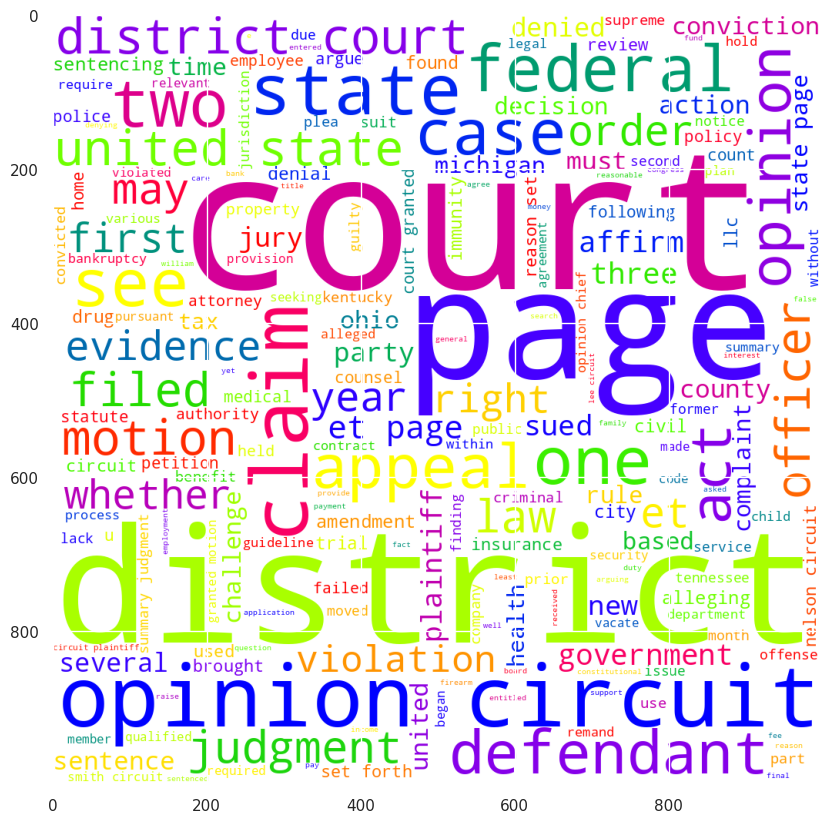

In [ ]:
# Word cloud of ALL opinions
wc = WordCloud(width=1000, height=1000, colormap='prism', background_color='white')

text = ' '.join([' '.join(get_opinion(dict[c])) for c in dict.keys()])
wc = wc.generate(text)

plt.figure(figsize=(10,10))
plt.imshow(wc)

In [ ]:
# Trying to only parse the opionion analysis
feats = [(get_opinion(dict[c]), c, ("remand" in c or "reverse" in c)) for c in dict.keys()]

# Use default sentiment analysis
sentiment_pipeline = pipeline("sentiment-analysis")
default_sentiment = sentiment_pipeline([' '.join(f[0]) for f in feats])

neg = 0
pos = 0
default_label = {}

for idx, s in enumerate(default_sentiment):
  if feats[idx][2] == False:
    default_label[feats[idx][1]] = 1
  else:
    default_label[feats[idx][1]] = 0
  if s['label'] == 'NEGATIVE':
    neg = neg + 1
  else:
    pos = pos + 1

print('Negative sentiment court cases ', neg)
print('Positive sentiment court cases ', pos)
print(default_label)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Negative sentiment court cases  255
Positive sentiment court cases  25
{'22a0037p.06': 1, '22a0015p.06': 1, '22b0001p.06': 1, '22a0081p.06': 1, '22a0095p.06': 1, '22a0046p.06': 1, '22a0236p.06': 1, '22a0264p.06': 1, '22a0042p.06': 1, '22a0127p.06': 1, '22a0090p.06': 1, '22a0056p.06': 1, '22a0173p.06': 1, '22a0170p.06': 1, '22a0094p.06': 1, '22a0224p.06': 1, '22a0255p.06': 1, '22a0040p.06': 1, '22a0162p.06': 1, '22a0097p.06': 1, '22a0098p.06': 1, '22a0020p.06': 1, '22a0012p.06': 1, '22a0014p.06': 1, '22b0002p.06': 1, '22a0055p.06': 1, '22a0113p.06': 1, '22b0003p.06': 1, '22a0 123p.0': 1, '22a0166p.06': 1, '22a0108p.06': 1, '22a0164p.06': 1, '22a0260p.06': 1, '22a0240p.06': 1, '22a0202p.06': 1, '22a0142p.06': 1, '22a0003p.06': 1, '22a0209p.06': 1, '22a0030p.06': 1, '22a0179p.06': 1, '22a0052p.06': 1, '22a0128p.06': 1, '22a0005p.06': 1, '22a0109p.06': 1, '22a0050p.06': 1, '22a0064p.06': 1, '22a0039p.06': 1, '22a0184p.06': 1, '22a0216p.06': 1, '22a0102p.06': 1, '22a0044p.06': 1, '22a0006p.

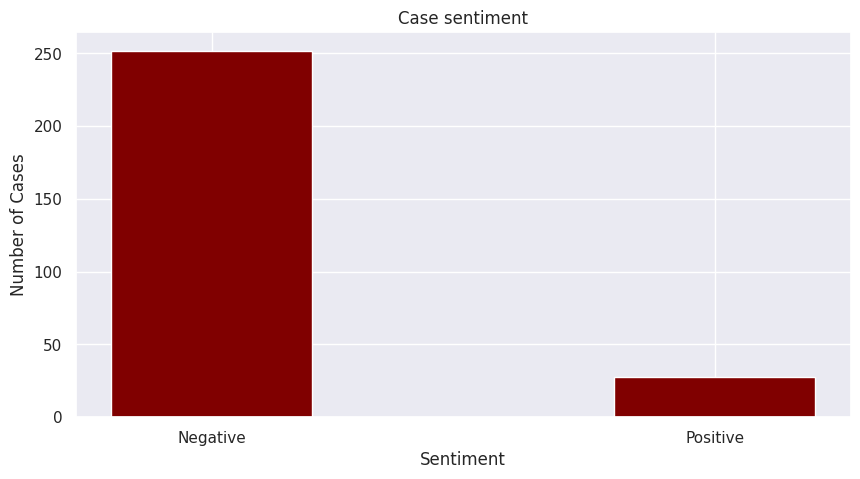

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
data = {'Negative':252, 'Positive':28}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Sentiment")
plt.ylabel("Number of Cases")
plt.title("Case sentiment")
plt.show()

In [ ]:
data = list()

ant_win_count = 0
ee_win_count = 0

for key, value in dict.items():
  text = dict[key]
  label = 1
  if "remand" in text or "reverse" in text:
    label = 0
    ant_win_count = ant_win_count + 1
  else:
    ee_win_count = ee_win_count + 1 
  data.append((select_words(text.split(' ')), label))
  #if key in labels:
    #data.append((select_words(dict[key].split(' ')), labels[key]))

print("Appellant win ", ant_win_count)
print("Appellee win ", ee_win_count)

train_x, test_x, train_y, test_y = train_test_split([d[0] for d in data], [d[1] for d in data])

# Concatenate train data and test data
all = [d[0] for d in data]

# Encode our concatenated data
encoded = [tokenizer.encode(sent, add_special_tokens=True) for sent in all]

# Find the maximum length
max_length = max([len(d) for d in encoded])

train_inputs, train_masks = preprocessing_for_bert(train_x, max_length)
val_inputs, val_masks = preprocessing_for_bert(test_x, max_length)

print('Training encoded input ', train_inputs)

Appellant win  166
Appellee win  114
Training encoded input  tensor([[ 101, 2156, 2457,  ..., 3627,  100,  102],
        [ 101,  100, 2212,  ..., 7409, 2095,  102],
        [ 101, 4058, 8909,  ..., 2212, 3076,  102],
        ...,
        [ 101,  100, 2457,  ..., 2047, 5136,  102],
        [ 101, 3119,  100,  ..., 3277, 3465,  102],
        [ 101, 2110, 2457,  ...,  100, 4618,  102]])


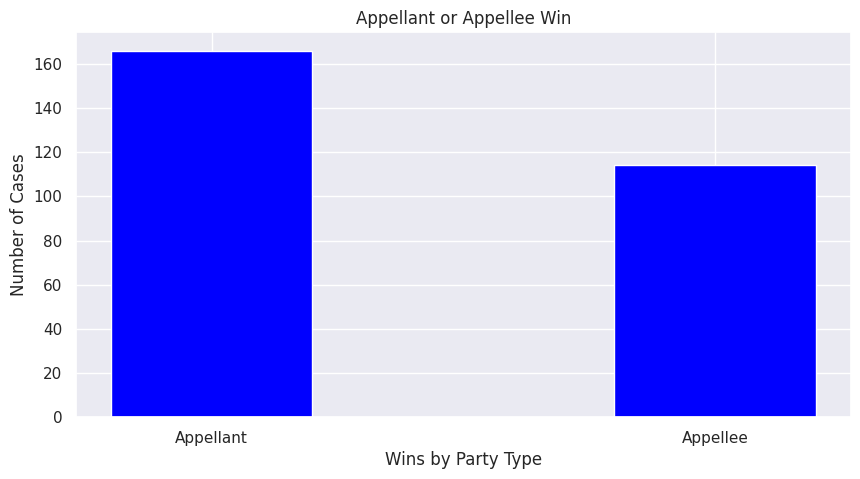

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
data = {'Appellant':166, 'Appellee':114}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='blue',
        width = 0.4)
 
plt.xlabel("Wins by Party Type")
plt.ylabel("Number of Cases")
plt.title("Appellant or Appellee Win")
plt.show()

In [ ]:
# Convert other data types to torch.Tensor
train_labels = torch.tensor(train_y)
val_labels = torch.tensor(test_y)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    6    |   0.703237   |     -      |     -     |  104.36  
----------------------------------------------------------------------
   1    |    -    |   0.703237   |  0.653288  |   68.40   |  113.82  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    6    |   0.688612   |     -      |     -     |  101.49  
----------------------------------------------------------------------
   2    |    -    |   0.688612   |  0.638166  |   68.40   |  111.20  
----------------------------------------------------------------------


Training complete!


AUC: 0.5577
Accuracy: 62.86%


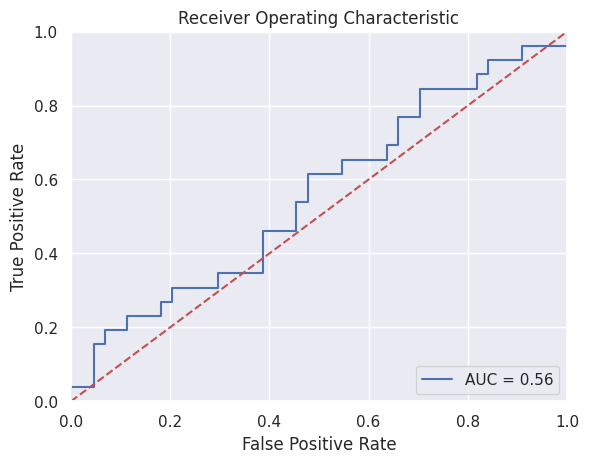

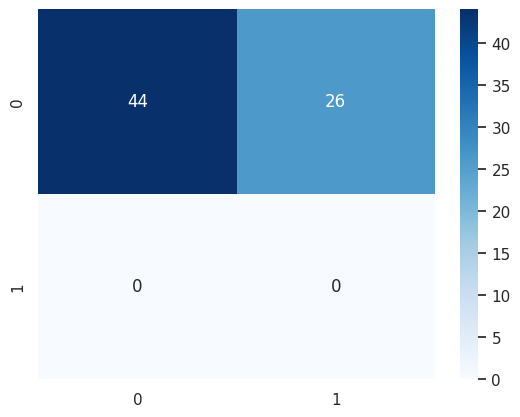

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, test_y)

In [ ]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, full_train_dataloader, epochs=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    8    |   0.686097   |     -      |     -     |  131.60  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    8    |   0.670270   |     -      |     -     |  130.95  
----------------------------------------------------------------------


Training complete!


AUC: 0.5018
Accuracy: 59.29%


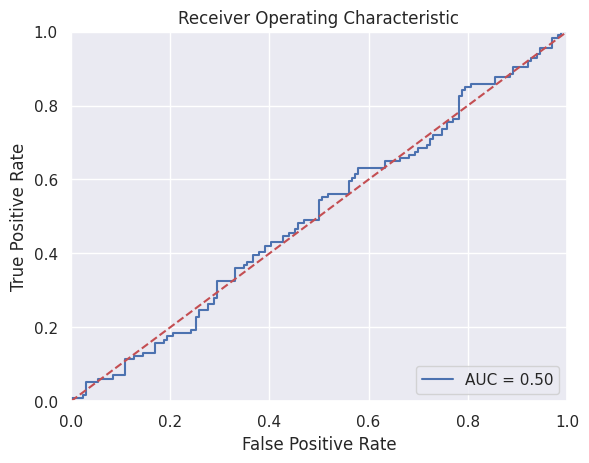

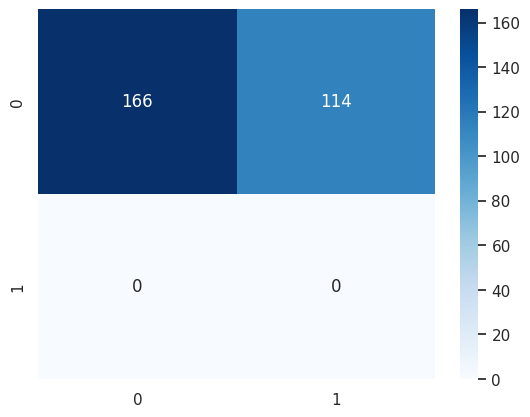

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, full_train_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, np.concatenate([train_y, test_y]))